In [1]:
from dask.distributed import LocalCluster, Client
from dask_jobqueue import SLURMCluster

import stackstac
import dask.array as da
import pystac_client
import geopandas as gpd
import planetary_computer as pc
import xarray as xr

import os

from PIL import Image, ImageDraw, ImageFont
from xarray.plot.utils import _rescale_imshow_rgb
import numpy as np
from typing import TYPE_CHECKING, BinaryIO, cast,Literal
import ntpath

from IPython.display import HTML, display
import folium
import folium.plugins
from branca.element import Figure
import shapely.geometry


In [2]:

cluster = LocalCluster(n_workers=5,
                       threads_per_worker=2,
                       dashboard_address=8787,
                       memory_limit='4GB')

client = Client(cluster)
#display(client)

2022-12-09 10:23:31,006 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kcf0s000', purging
2022-12-09 10:23:31,288 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-9tekp4ed', purging
2022-12-09 10:23:31,439 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ankuw10x', purging


cluster = SLURMCluster(
    account="wp1",
    cores=10,
    memory="20 GB",
    walltime="03:00:00"
)

cluster

cluster.scale(jobs=10,memory=40)  # ask for 10 jobs
client = Client(cluster)
print(client)


In [3]:
client.scheduler_info()

{'type': 'Scheduler',
 'id': 'Scheduler-251c625e-2e11-4b25-929f-0d6a10b4acc4',
 'address': 'tcp://127.0.0.1:42071',
 'services': {'dashboard': 8787},
 'started': 1670577810.3278115,
 'workers': {'tcp://127.0.0.1:37219': {'type': 'Worker',
   'id': 2,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-worker-space/worker-e5nsubhs',
   'name': 2,
   'nthreads': 2,
   'memory_limit': 4000000000,
   'last_seen': 1670577817.207124,
   'services': {'dashboard': 39663},
   'metrics': {'executing': 0,
    'in_memory': 0,
    'ready': 0,
    'in_flight': 0,
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.01997285842895508,
    'cpu': 2.0,
    'memory': 89128960,
    'time': 1670577817.2024035,
    'host_net_io': {'read_bps': 47215.03389049166,
     'write_bps': 47215.03389049166},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 16366.333416447664},
    'num_fds': 24},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:35605'},
  'tcp://127.0.0.1:39181': {'type': 'Worker',
   'id': 0,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-worker-space/worker-tz4uop6z',
   'name': 0,
   'nthreads': 2,
   'memory_limit': 4000000000,
   'last_seen': 1670577817.2061477,
   'services': {'dashboard': 35907},
   'metrics': {'executing': 0,
    'in_memory': 0,
    'ready': 0,
    'in_flight': 0,
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02001211166381836,
    'cpu': 4.0,
    'memory': 87072768,
    'time': 1670577817.201348,
    'host_net_io': {'read_bps': 46791.53057948984,
     'write_bps': 46791.53057948984},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 16355.174233356689},
    'num_fds': 24},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:40695'},
  'tcp://127.0.0.1:39689': {'type': 'Worker',
   'id': 3,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-worker-space/worker-cy9nc9tj',
   'name': 3,
   'nthreads': 2,
   'memory_limit': 4000000000,
   'last_seen': 1670577817.2292418,
   'services': {'dashboard': 37511},
   'metrics': {'executing': 0,
    'in_memory': 0,
    'ready': 0,
    'in_flight': 0,
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.019970498085021972,
    'cpu': 6.0,
    'memory': 91361280,
    'time': 1670577817.216129,
    'host_net_io': {'read_bps': 47940.77051293999,
     'write_bps': 47940.77051293999},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 16430.188346316547},
    'num_fds': 24},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:42485'},
  'tcp://127.0.0.1:44343': {'type': 'Worker',
   'id': 1,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-worker-space/worker-f36mly47',
   'name': 1,
   'nthreads': 2,
   'memory_limit': 4000000000,
   'last_seen': 1670577817.1857212,
   'services': {'dashboard': 44875},
   'metrics': {'executing': 0,
    'in_memory': 0,
    'ready': 0,
    'in_flight': 0,
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     

In [4]:
from dask.utils import ensure_dict, format_bytes
    
wk = client.scheduler_info()["workers"]

text="Workers= " + str(len(wk))
memory = [w["memory_limit"] for w in wk.values()]
cores = sum(w["nthreads"] for w in wk.values())
text += ", Cores=" + str(cores)
if all(memory):
    text += ", Memory=" + format_bytes(sum(memory))
print(text)

Workers= 5, Cores=10, Memory=18.63 GiB


In [5]:
# Define general variables

setting = {'spatial_resolution' : 500,
            'cloud_cover': 5}

glacier = "thwaites"
full_name= "Thwaites"

#glacier = "amundsen"
#full_name= "Amundsen bay"


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))



#filename = "geojson file path"
filename = glacier +".geojson"

# read in AOI as a GeoDataFrame
aoi = gpd.read_file(filename)
bbox =aoi.unary_union.bounds

In [6]:
#filename = "geojson file path"
filename = glacier +".geojson"
# read in AOI as a GeoDataFrame
aoi = gpd.read_file(filename)

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    aoi['geometry'],
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)


map1.fit_bounds(bounds=convert_bounds(aoi.unary_union.bounds))
display(fig)

In [7]:
# With the pystac_client module’s Client class, Open the STAC API. 
datetimeRange=[]
for t in range (2020,2022):
    datetimeRange.append(str(t-1)+"-12-1/"+str(t)+"-03-30")

ImSatSTAC = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = (
    ImSatSTAC
    .search(
        bbox=bbox,
        datetime = datetimeRange, 
        collections = ["modis-09A1-061"],
        #query={"sat:orbit_state": dict(eq="descending")}
               
    )
)
items = pc.sign(search)
print(str(len(items))+ ' scenes found')

79 scenes found


In [11]:
stack = stackstac.stack(items, bounds_latlon=bbox, epsg = 3031,resolution=250)
stack.coords

Coordinates:
  * time                   (time) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    id                     (time) <U41 'MYD09A1.A2020361.h14v16.061.202101209...
  * band                   (band) <U20 'sur_refl_b01' ... 'sur_refl_day_of_year'
  * x                      (x) float64 -1.68e+06 -1.679e+06 ... -1.509e+06
  * y                      (y) float64 -3.688e+05 -3.69e+05 ... -5.972e+05
    proj:transform         object {0.0, -4447802.078667, 463.3127165279167, -...
    start_datetime         (time) <U20 '2020-12-26T00:00:00Z' ... '2019-11-25...
    proj:geometry          object {'type': 'Polygon', 'coordinates': [[[-3335...
    updated                (time) <U27 '2021-01-12T03:10:17.786000Z' ... '202...
    platform               (time) <U5 'aqua' 'terra' 'aqua' ... 'aqua' 'terra'
    proj:epsg              object None
    proj:shape             object {2400}
    end_datetime           (time) <U20 '2021-01-02T23:59:59Z' ... '2019-12-02...
    created                (ti

In [14]:
# keep rgb bands + Make annual median composites (`Q` means 2 quarters)
composites = stack.sel(band=["sur_refl_b01", "sur_refl_b04", "sur_refl_b03"])
composites.ffill("time").bfill("time")

ts = composites.persist()
ts_local = ts.compute()

ts_local

<xarray.DataArray 'stackstac-37ca3753d07d2b16c797b7dff2f17d1e' (time: 79,
                                                                band: 3,
                                                                y: 915, x: 684)>
array([[[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 6409.,  3230.,  3230., ...,    nan,    nan,    nan],
         [ 8189.,  6409.,  3230., ...,    nan,    nan,    nan],
         [ 8189.,  8189.,  8189., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 6789.,  2799.,  2799., ...,    nan,    nan,    nan],
         [ 7732.,  6789.,  2799., ...,    nan,    nan,    nan],
         [ 7732.,  7732.,  7732., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
...
         ...,
         [ 6343., 13022., 13155., ...,    nan,    nan,    nan],
         [ 6442.,  6343., 13022., ...,    nan,    nan,    nan],
         [ 6442.,  6442., 13671., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 6945., 12522., 12575., ...,    nan,    nan,    nan],
         [ 6857.,  6945., 12522., ...,    nan,    nan,    nan],
         [ 6857.,  6857., 12977., ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [ 7456., 10644., 10763., ...,    nan,    nan,    nan],
         [ 7184.,  7456., 10644., ...,    nan,    nan,    nan],
         [ 7184.,  7184., 10852., ...,    nan,    nan,    nan]]]])
Coordinates: (12/25)
  * time                   (time) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    id                     (time) <U41 'MYD09A1.A2020361.h14v16.061.202101209...
  * band                   (band) <U20 'sur_refl_b01' ... 'sur_refl_b03'
  * x                      (x) float64 -1.68e+06 -1.679e+06 ... -1.509e+06
  * y                      (y) float64 -3.688e+05 -3.69e+05 ... -5.972e+05
    proj:transform         object {0.0, -4447802.078667, 463.3127165279167, -...
    ...                     ...
    raster:bands           (band) object {'scale': 0.0001, 'data_type': 'int1...
    title                  (band) <U51 'Surface Reflectance Band 1 (620-670 n...
    common_name            (band) object 'red' 'green' 'blue'
    center_wavelength      (band) object 0.645 0.555 0.469
    full_width_half_max    (band) object 0.5 0.2 0.2
    epsg                   int64 3031
Attributes:
    spec:        RasterSpec(epsg=3031, bounds=(-1679500, -597500, -1508500, -...
    crs:         epsg:3031
    transform:   | 250.00, 0.00,-1679500.00|\n| 0.00,-250.00,-368750.00|\n| 0...
    resolution:  250

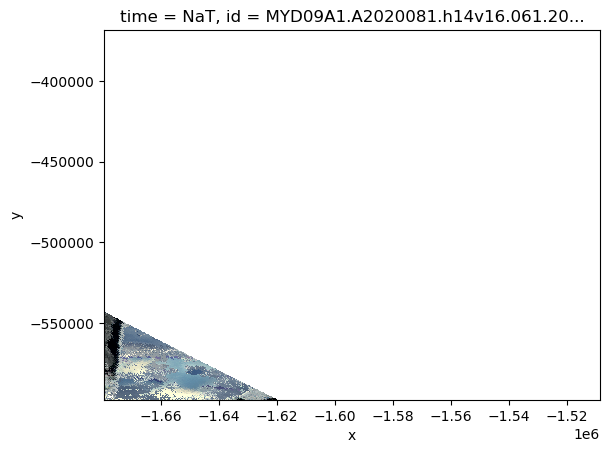

In [19]:

ts_local[47].plot.imshow(rgb="band",  robust=True)